## Start a SparkSession
This will start a local Spark session.

In [1]:
# Starter code
from pyspark.sql import SparkSession

# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [2]:
from pyspark.sql.functions import add_months, avg, count, countDistinct, col, datediff,\
desc, expr, from_unixtime, floor, isnan, lag, lit, month, months_between,\
min, max, split, sum, udf, unix_timestamp, when, year
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

from scikitplot.metrics import plot_calibration_curve, plot_confusion_matrix
from scikitplot.plotters import plot_learning_curve
from scikitplot.estimators import plot_feature_importances

## Load and Clean Data

## Load and Clean Datasets
Load and inspect Datasets. We load the medium size dataset `medium-sparkify-event-data.json`.

In [3]:
df = spark.read.json('/Users/leandrohandal/Downloads/medium-sparkify-event-data.json')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Investigate timestamps

In [5]:
df.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              543705|
|   mean|1.540964541209743...|
| stddev|1.4820571449120703E9|
|    min|       1538352011000|
|    max|       1543622466000|
+-------+--------------------+



In [6]:
ts = int(1538352001000)
ts /= 1000
print("Start Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

ts = int(1543622402000)
ts /= 1000
print("End Time: {}".format(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')))

Start Time: 2018-10-01 00:00:01
End Time: 2018-12-01 00:00:02


There are 2 months of data available

### Investigate pages

In [7]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



### Investigate missing and null values

In [8]:
# check NaN values per column
# taken from: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [9]:
# check null values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



### Cleaning data

In [10]:
# filter out all entries with missing names.
# they are not recording information that we will need for the model
df = df.filter(df.firstName.isNotNull())

In [11]:
# original timestamp in milliseconds, so divide by 1000
adjust_timestamp = udf(lambda x : x//1000, IntegerType())
df = df.withColumn("ts_adj", adjust_timestamp('ts'))

# convert adjusted timestamp to datetime
df = df.withColumn("datetime", from_unixtime(col("ts_adj")))

# convert registration timestamp to datetime
df = df.withColumn("reg_adj", adjust_timestamp('registration'))

# convert adjusted registration timestamp to datetime
df = df.withColumn("reg_datetime", from_unixtime(col("reg_adj")))

# drop all the timestamp columns. Will not need them
columns_to_drop = ['registration', 'ts', 'ts_adj', 'reg_adj']
df = df.drop(*columns_to_drop)

# add start date of analysis
df = df.withColumn('analysis_start_date', lit('2018-10-01 00:00:00'))

# number the months starting from the very first month of the analysis
df = df.withColumn("month_num", floor(months_between(df.datetime, df.analysis_start_date)))

In [12]:
# engineer free or paid binary variable
# free: 0, paid: 1
df = df.replace(["free", "paid"], ["0", "1"], "level")

# engineer male and female binary binary variable
# male: 0, female: 1
df = df.replace(["M", "F"], ["0", "1"], "gender")

### Define Churn

In [13]:
# can possibly switch to a 2-class classification system
def define_churn(x):
    """
    Defining churn as cancellation of service or downgrading from premium to free tier.
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : define_churn(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

df.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+------------------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|sessionId|              song|status|           userAgent|userId|           datetime|       reg_datetime|analysis_start_date|month_num|churn|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+---------+------------------+------+--------------------+------+-------------------+-------------------+-------------------+---------+-----+
|    Martin Orford|Logged In|   Joseph|     0|           20| Morales|597.55057|    0|  Corpus Christi, TX|   PUT|NextSong|      292|     Grand Designs|   200|"Mozilla/5.0 (Mac...|   293|2018-10-01 02:00:11|2018-

In [14]:
# aggregate number of page visits for each user on a monthly basis

df_upgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Upgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numUpgradeVisits')

df_downgrade = df.select('userId', 'month_num', 'page') \
.where(df.page=="Downgrade") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numDowngradeVisits')

df_home = df.select('userId', 'month_num', 'page') \
.where(df.page=="Home") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numHomeVisits')

df_about = df.select('userId', 'month_num', 'page') \
.where(df.page=="About") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAboutVisits')

df_settings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSettingsVisits')

df_saveSettings = df.select('userId', 'month_num', 'page') \
.where(df.page=="Save Settings") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSaveSettings')

df_logout = df.select('userId', 'month_num', 'page') \
.where(df.page=="Logout") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numLogouts')

df_addPlaylist = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add to Playlist") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAddPlaylists')

df_addFriend = df.select('userId', 'month_num', 'page') \
.where(df.page=="Add Friend") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numFriends')

df_thumbsUp = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Up") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsUp')

df_thumbsDown = df.select('userId', 'month_num', 'page') \
.where(df.page=="Thumbs Down") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numThumbsDown')

df_advert = df.select('userId', 'month_num', 'page') \
.where(df.page=="Roll Advert") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numAdverts')

df_songsPlayed = df.select('userId', 'month_num', 'page') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'numSongsPlayed')

df_totalListen = df.select('userId', 'month_num', 'length') \
.groupBy('userId', 'month_num') \
.agg({'length':'sum'}) \
.withColumnRenamed('sum(length)', 'totalListenTime')

# number of songs per session
df_songsPerSession = df.select('userId', 'month_num', 'page', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg({'page':'count'}) \
.withColumnRenamed('count(page)', 'SongsPerSession')
# avg number of songs per session
df_avgSongsPerSession = df_songsPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_songsPerSession.SongsPerSession).alias('avgSongsPerSession'))

# number of singers
df_singersPlayed = df.select('userId', 'month_num', 'page', 'artist') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num') \
.agg(countDistinct(df.artist).alias('numSingersPlayed'))

# number of singers per session
df_singersPerSession = df.select('userId', 'month_num', 'page', 'artist', 'sessionId') \
.where(df.page=="NextSong") \
.groupBy('userId', 'month_num', 'sessionId') \
.agg(countDistinct(df.artist).alias('SingersPerSession'))
# avg number of singers per session
df_avgSingersPerSession = df_singersPerSession.groupBy('userId', 'month_num') \
.agg(avg(df_singersPerSession.SingersPerSession).alias('avgSingersPerSession'))

# groupby user, month_num, sessionId.
df_userSession = df.groupBy("userId", "month_num", "sessionId") \
.agg(((max(unix_timestamp(df.datetime))-min(unix_timestamp(df.datetime)))/60.0).alias('sessionTimeMins'))
# Find avg session time
df_avgUserSession = df_userSession.groupBy('userId', 'month_num').agg(avg(df_userSession.sessionTimeMins).alias('avgSessionMins'))

# number of sessions
df_numSession = df.select('userId', 'month_num', 'sessionId').dropDuplicates() \
.groupby('userId', 'month_num').agg({'sessionId':'count'}) \
.withColumnRenamed('count(sessionId)', 'numSessions')

# if user had premium at any point of the month, assumer he/she has premium for
# the whole month for simplicity
df_level = df.select('userId', 'month_num', 'level') \
.groupBy('userId', 'month_num') \
.agg({'level':'max'}) \
.withColumnRenamed('max(level)', 'level')

# assuming nobody changes gender midway
df_gender = df.select('userId', 'month_num', 'gender') \
.groupBy('userId', 'month_num') \
.agg({'gender':'max'}) \
.withColumnRenamed('max(gender)', 'gender')

# start of each month
# from https://stackoverflow.com/questions/45612208/add-months-to-date-column-in-spark-dataframe
df = df.withColumn("start_of_month", expr("add_months(analysis_start_date, month_num)"))
# days since registration from start of each month
# from https://stackoverflow.com/questions/44020818/how-to-calculate-date-difference-in-pyspark
df = df.withColumn("daysSinceReg", datediff(df.start_of_month, df.reg_datetime))
#
df_daysReg = df.select('userId', 'month_num', 'daysSinceReg') \
.groupBy('userId', 'month_num') \
.agg(min(df.daysSinceReg).alias('daysSinceReg'))

df_churn = df.select('userId', 'month_num', 'churn') \
.groupBy('userId', 'month_num') \
.agg({'churn':'max'}) \
.withColumnRenamed('max(churn)', 'churn')

In [15]:
all_data = df_upgrade.join(df_downgrade, ['userId', 'month_num'], 'outer') \
.join(df_home, ['userId', 'month_num'], 'outer') \
.join(df_about, ['userId', 'month_num'], 'outer') \
.join(df_settings, ['userId', 'month_num'], 'outer') \
.join(df_saveSettings, ['userId', 'month_num'], 'outer') \
.join(df_logout, ['userId', 'month_num'], 'outer') \
.join(df_addPlaylist, ['userId', 'month_num'], 'outer') \
.join(df_addFriend, ['userId', 'month_num'], 'outer') \
.join(df_thumbsUp, ['userId', 'month_num'], 'outer') \
.join(df_thumbsDown, ['userId', 'month_num'], 'outer') \
.join(df_advert, ['userId', 'month_num'], 'outer') \
.join(df_songsPlayed, ['userId', 'month_num'], 'outer') \
.join(df_totalListen, ['userId', 'month_num'], 'outer') \
.join(df_avgSongsPerSession, ['userId', 'month_num'], 'outer') \
.join(df_singersPlayed, ['userId', 'month_num']) \
.join(df_avgSingersPerSession, ['userId', 'month_num'], 'outer') \
.join(df_avgUserSession, ['userId', 'month_num'], 'outer') \
.join(df_numSession, ['userId', 'month_num'], 'outer') \
.join(df_level, ['userId', 'month_num'], 'outer') \
.join(df_gender, ['userId', 'month_num'], 'outer') \
.join(df_daysReg, ['userId', 'month_num'], 'outer') \
.join(df_churn, ['userId', 'month_num'], 'outer')

In [16]:
all_data.select([count(when(col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+------+---------+----------------+------------------+-------------+--------------+-----------------+---------------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+------------------+----------------+--------------------+--------------+-----------+-----+------+------------+-----+
|userId|month_num|numUpgradeVisits|numDowngradeVisits|numHomeVisits|numAboutVisits|numSettingsVisits|numSaveSettings|numLogouts|numAddPlaylists|numFriends|numThumbsUp|numThumbsDown|numAdverts|numSongsPlayed|totalListenTime|avgSongsPerSession|numSingersPlayed|avgSingersPerSession|avgSessionMins|numSessions|level|gender|daysSinceReg|churn|
+------+---------+----------------+------------------+-------------+--------------+-----------------+---------------+----------+---------------+----------+-----------+-------------+----------+--------------+---------------+------------------+----------------+--------------------+--------------+-----------+-----+------+

In [17]:
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

In [18]:
windowlag = (Window.partitionBy('userId').orderBy('month_num'))

# generate 1 month lag features
all_data = all_data.withColumn('numUpgradeVisits_lastMonth', lag(all_data['numUpgradeVisits']).over(windowlag))
all_data = all_data.withColumn('numDowngradeVisits_lastMonth', lag(all_data['numDowngradeVisits']).over(windowlag))
all_data = all_data.withColumn('numHomeVisits_lastMonth', lag(all_data['numHomeVisits']).over(windowlag))
all_data = all_data.withColumn('numAboutVisits_lastMonth', lag(all_data['numAboutVisits']).over(windowlag))
all_data = all_data.withColumn('numSettingsVisits_lastMonth', lag(all_data['numSettingsVisits']).over(windowlag))
all_data = all_data.withColumn('numSaveSettings_lastMonth', lag(all_data['numSaveSettings']).over(windowlag))
all_data = all_data.withColumn('numLogouts_lastMonth', lag(all_data['numLogouts']).over(windowlag))
all_data = all_data.withColumn('numAddPlaylists_lastMonth', lag(all_data['numAddPlaylists']).over(windowlag))
all_data = all_data.withColumn('numFriends_lastMonth', lag(all_data['numFriends']).over(windowlag))
all_data = all_data.withColumn('numThumbsUp_lastMonth', lag(all_data['numThumbsUp']).over(windowlag))
all_data = all_data.withColumn('numThumbsDown_lastMonth', lag(all_data['numThumbsDown']).over(windowlag))
all_data = all_data.withColumn('numAdverts_lastMonth', lag(all_data['numAdverts']).over(windowlag))
all_data = all_data.withColumn('numSongsPlayed_lastMonth', lag(all_data['numSongsPlayed']).over(windowlag))
all_data = all_data.withColumn('totalListenTime_lastMonth', lag(all_data['totalListenTime']).over(windowlag))
all_data = all_data.withColumn('avgSongsPerSession_lastMonth', lag(all_data['avgSongsPerSession']).over(windowlag))
all_data = all_data.withColumn('numSingersPlayed_lastMonth', lag(all_data['numSingersPlayed']).over(windowlag))
all_data = all_data.withColumn('avgSingersPerSession_lastMonth', lag(all_data['avgSingersPerSession']).over(windowlag))
all_data = all_data.withColumn('avgSessionMins_lastMonth', lag(all_data['avgSessionMins']).over(windowlag))
all_data = all_data.withColumn('numSessions_lastMonth', lag(all_data['numSessions']).over(windowlag))
all_data = all_data.withColumn('level_lastMonth', lag(all_data['level']).over(windowlag))

### Additional Data Adjustments

In [19]:
# convert userId, gender, level, level_lastMonth to numeric
convert_numeric = ['userId', 'level', 'gender', 'level_lastMonth']
for feat in convert_numeric:
    featName = feat + "_n"
    all_data = all_data.withColumn(featName, all_data[feat].cast("float"))
    all_data = all_data.drop(feat)
    
# fill na/null values with 0
all_data = all_data.na.fill(0.0)

In [20]:
all_data.persist()

DataFrame[month_num: bigint, numUpgradeVisits: bigint, numDowngradeVisits: bigint, numHomeVisits: bigint, numAboutVisits: bigint, numSettingsVisits: bigint, numSaveSettings: bigint, numLogouts: bigint, numAddPlaylists: bigint, numFriends: bigint, numThumbsUp: bigint, numThumbsDown: bigint, numAdverts: bigint, numSongsPlayed: bigint, totalListenTime: double, avgSongsPerSession: double, numSingersPlayed: bigint, avgSingersPerSession: double, avgSessionMins: double, numSessions: bigint, daysSinceReg: int, churn: int, numUpgradeVisits_lastMonth: bigint, numDowngradeVisits_lastMonth: bigint, numHomeVisits_lastMonth: bigint, numAboutVisits_lastMonth: bigint, numSettingsVisits_lastMonth: bigint, numSaveSettings_lastMonth: bigint, numLogouts_lastMonth: bigint, numAddPlaylists_lastMonth: bigint, numFriends_lastMonth: bigint, numThumbsUp_lastMonth: bigint, numThumbsDown_lastMonth: bigint, numAdverts_lastMonth: bigint, numSongsPlayed_lastMonth: bigint, totalListenTime_lastMonth: double, avgSongsP

In [21]:
all_data.columns

['month_num',
 'numUpgradeVisits',
 'numDowngradeVisits',
 'numHomeVisits',
 'numAboutVisits',
 'numSettingsVisits',
 'numSaveSettings',
 'numLogouts',
 'numAddPlaylists',
 'numFriends',
 'numThumbsUp',
 'numThumbsDown',
 'numAdverts',
 'numSongsPlayed',
 'totalListenTime',
 'avgSongsPerSession',
 'numSingersPlayed',
 'avgSingersPerSession',
 'avgSessionMins',
 'numSessions',
 'daysSinceReg',
 'churn',
 'numUpgradeVisits_lastMonth',
 'numDowngradeVisits_lastMonth',
 'numHomeVisits_lastMonth',
 'numAboutVisits_lastMonth',
 'numSettingsVisits_lastMonth',
 'numSaveSettings_lastMonth',
 'numLogouts_lastMonth',
 'numAddPlaylists_lastMonth',
 'numFriends_lastMonth',
 'numThumbsUp_lastMonth',
 'numThumbsDown_lastMonth',
 'numAdverts_lastMonth',
 'numSongsPlayed_lastMonth',
 'totalListenTime_lastMonth',
 'avgSongsPerSession_lastMonth',
 'numSingersPlayed_lastMonth',
 'avgSingersPerSession_lastMonth',
 'avgSessionMins_lastMonth',
 'numSessions_lastMonth',
 'userId_n',
 'level_n',
 'gender_n',
 

In [22]:
# drop month 0 since we do not have old information to predict churn for this month
# keep only features to be trained and labels

model_data = all_data \
.filter(all_data.month_num>0) \
.select('userId_n', 'month_num',\
        'numUpgradeVisits_lastMonth', 'numDowngradeVisits_lastMonth',\
        'numHomeVisits_lastMonth', 'numAboutVisits_lastMonth',\
        'numSettingsVisits_lastMonth', 'numSaveSettings_lastMonth',\
        'numLogouts_lastMonth', \
        'numAddPlaylists_lastMonth', 'numFriends_lastMonth',\
        'numThumbsUp_lastMonth', 'numThumbsDown_lastMonth',\
        'numAdverts_lastMonth', 'numSongsPlayed_lastMonth',\
        'totalListenTime_lastMonth', 'avgSongsPerSession_lastMonth',\
        'numSingersPlayed_lastMonth', 'avgSingersPerSession_lastMonth',\
        'avgSessionMins_lastMonth', 'numSessions_lastMonth',\
        'level_lastMonth_n',\
        'gender_n', 'daysSinceReg', 'churn'
        ).withColumnRenamed('churn', 'label')

#model_data.show(1)

## Converting to Pandas

In [23]:
data = all_data.toPandas()

In [24]:
data.head()

,month_num,numUpgradeVisits,numDowngradeVisits,numHomeVisits,numAboutVisits,numSettingsVisits,numSaveSettings,numLogouts,numAddPlaylists,numFriends,...,totalListenTime_lastMonth,avgSongsPerSession_lastMonth,numSingersPlayed_lastMonth,avgSingersPerSession_lastMonth,avgSessionMins_lastMonth,numSessions_lastMonth,userId_n,level_n,gender_n,level_lastMonth_n
0,0,2,0,3,0,0,0,1,1,3,...,0.00000,0.0,0,0.0,0.000000,0,100010.0,0.0,1.0,0.0
1,0,2,3,23,1,2,0,11,6,2,...,0.00000,0.0,0,0.0,0.000000,0,200002.0,1.0,0.0,0.0
2,0,1,1,7,0,1,0,3,3,2,...,0.00000,0.0,0,0.0,0.000000,0,296.0,1.0,1.0,0.0
3,0,0,0,1,0,3,0,0,1,3,...,0.00000,0.0,0,0.0,0.000000,0,125.0,0.0,0.0,0.0
4,1,0,0,1,0,0,0,0,1,0,...,14632.72472,29.0,57,28.5,118.066667,2,125.0,0.0,0.0,0.0


## Train Test Split

In [25]:
X, y = data.drop(columns=["churn"]), data["churn"]

In [26]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [28]:
lr = LogisticRegression(C=1.0, penalty='l2')
lr_model = lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [29]:
lr_accuracy = round(accuracy_score(y_test, y_pred_lr), 4)
lr_precision = round(precision_score(y_test, y_pred_lr), 4)
lr_recall = round(recall_score(y_test, y_pred_lr), 4)
lr_f1 = round(f1_score(y_test, y_pred_lr), 4)
print(f'Logistic Regression Accuracy: {lr_accuracy}')
print(f'Logistic Regression Precision: {lr_precision}')
print(f'Logistic Regression Recall: {lr_recall}')
print(f'Logistic Regression F1 Score: {lr_f1}')

Logistic Regression Accuracy: 0.7706
Logistic Regression Precision: 0.6667
Logistic Regression Recall: 0.2273
Logistic Regression F1 Score: 0.339


In [30]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
lr=LogisticRegression()
lr_opt=GridSearchCV(lr,grid,cv=10)
lr_opt.fit(X,y)
y_pred_lr_opt = lr_opt.predict(X)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed

In [66]:
print("Tuned (best) hpyerparameters",lr_opt.best_params_)

Tuned (best) hpyerparameters {'C': 1.0, 'penalty': 'l2'}


In [32]:
lr_optaccuracy = round(accuracy_score(y, y_pred_lr_opt), 4)
lr_optprecision = round(precision_score(y, y_pred_lr_opt), 4)
lr_optrecall = round(recall_score(y, y_pred_lr_opt), 4)
lr_optf1 = round(f1_score(y, y_pred_lr_opt), 4)
print(f'Logistic Regression Accuracy: {lr_optaccuracy}')
print(f'Logistic Regression Precision: {lr_optprecision}')
print(f'Logistic Regression Recall: {lr_optrecall}')
print(f'Logistic Regression F1 Score: {lr_optf1}')

Logistic Regression Accuracy: 0.8205
Logistic Regression Precision: 0.7416
Logistic Regression Recall: 0.3385
Logistic Regression F1 Score: 0.4648


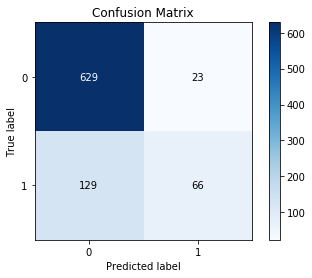

In [33]:
plot_confusion_matrix(y, y_pred_lr_opt);

### Linear SVC

In [53]:
svc = SVC(kernel='linear', C=1000)
svc_model = svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

In [54]:
svc_accuracy = round(accuracy_score(y_test, y_pred_svc), 4)
svc_precision = round(precision_score(y_test, y_pred_svc), 4)
svc_recall = round(recall_score(y_test, y_pred_svc), 4)
svc_f1 = round(f1_score(y_test, y_pred_svc), 4)
print(f'SVC Accuracy: {svc_accuracy}')
print(f'SVC Precision: {svc_precision}')
print(f'SVC Recall: {svc_recall}')
print(f'SVC F1 Score: {svc_f1}')

SVC Accuracy: 0.7529
SVC Precision: 0.5625
SVC Recall: 0.2045
SVC F1 Score: 0.3


In [160]:
print("Tuned (best) hpyerparameters",svc_opt.best_params_)
print("Accuracy:",svc_opt.best_score_)

Tuned (best) hpyerparameters {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.7981109799291618


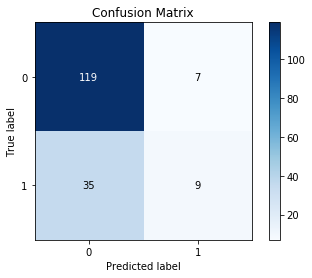

In [57]:
plot_confusion_matrix(y_test, y_pred_svc);

### Gradient Boosted Trees

In [58]:
gbc = GradientBoostingClassifier()
gbc_model = gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)

In [59]:
gbc_accuracy = round(accuracy_score(y_test, y_pred_gbc), 4)
gbc_precision = round(precision_score(y_test, y_pred_gbc), 4)
gbc_recall = round(recall_score(y_test, y_pred_gbc), 4)
gbc_f1 = round(f1_score(y_test, y_pred_gbc), 4)
print(f'Gradient Boosted Trees Accuracy: {gbc_accuracy}')
print(f'Gradient Boosted Trees Precision: {gbc_precision}')
print(f'Gradient Boosted Trees Recall: {gbc_recall}')
print(f'Gradient Boosted Trees F1 Score: {gbc_f1}')

Gradient Boosted Trees Accuracy: 0.7706
Gradient Boosted Trees Precision: 0.619
Gradient Boosted Trees Recall: 0.2955
Gradient Boosted Trees F1 Score: 0.4


In [62]:
grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 5),
    "min_samples_leaf": np.linspace(0.1, 0.5, 5),
    "max_depth":[3,5,8],
    "n_estimators":[10, 100, 1000]
    }
gbc=GradientBoostingClassifier()
gbc_opt=GridSearchCV(gbc,grid,cv=3)
gbc_opt.fit(X,y)
y_pred_gbc_opt = gbc_opt.predict(X)

In [65]:
print("Tuned (best) hpyerparameters",gbc_opt.best_params_)

Tuned (best) hpyerparameters {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'n_estimators': 100}


In [64]:
gbc_optaccuracy = round(accuracy_score(y, y_pred_gbc_opt), 4)
gbc_optprecision = round(precision_score(y, y_pred_gbc_opt), 4)
gbc_optrecall = round(recall_score(y, y_pred_gbc_opt), 4)
gbc_optf1 = round(f1_score(y, y_pred_gbc_opt), 4)
print(f'Gradient Boosted Trees Accuracy: {gbc_optaccuracy}')
print(f'Gradient Boosted Trees Precision: {gbc_optprecision}')
print(f'Gradient Boosted Trees Recall: {gbc_optrecall}')
print(f'Gradient Boosted Trees F1 Score: {gbc_optf1}')

Gradient Boosted Trees Accuracy: 0.8749
Gradient Boosted Trees Precision: 0.856
Gradient Boosted Trees Recall: 0.5487
Gradient Boosted Trees F1 Score: 0.6688


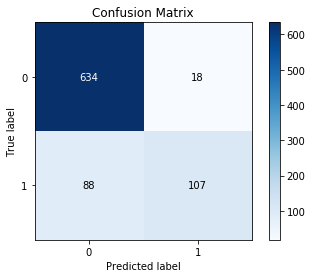

In [69]:
plot_confusion_matrix(y, y_pred_gbc_opt);

## Feature Importance

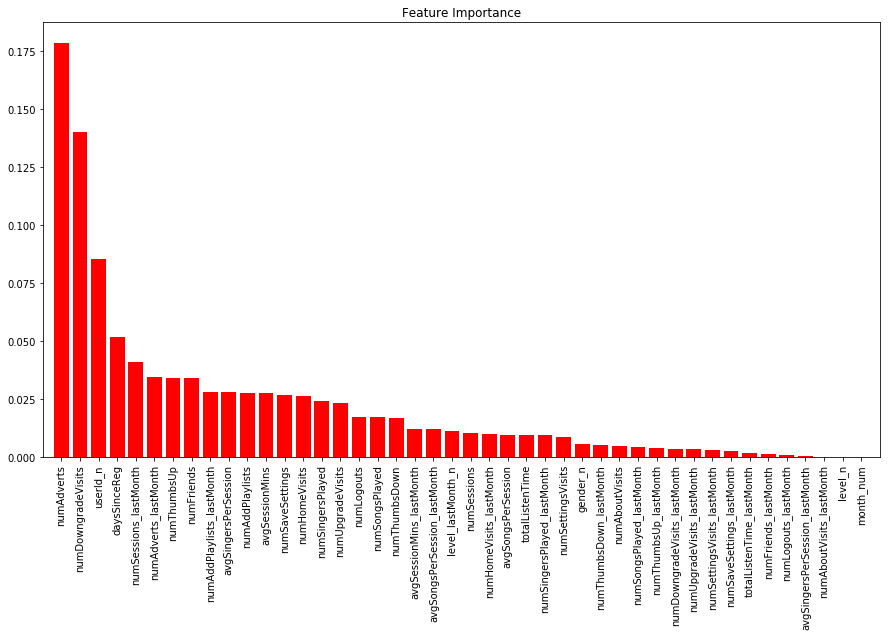

In [79]:
fig, ax = plt.subplots(figsize=(15,8))
plot_feature_importances(gbc_model, max_num_features=50, feature_names=X.columns, x_tick_rotation=90, ax=ax)